In [1]:
import pandas as pd
import psycopg2
import re
from sklearn.model_selection import train_test_split

In [2]:
def balance_samples(df_1, df_2):
    lengths = [len(df_1), len(df_2)]

    if lengths[0] < lengths[1]:
        new_df_1 = df_1
        new_df_2 = df_2.sample(lengths[0])
    elif lengths[0] > lengths[1]:
        new_df_1 = df_1.sample(lengths[1])
        new_df_2 = df_2
    else:
        new_df_1 = df_1
        new_df_2 = df_2

    return new_df_1.append(new_df_2).sample(frac=1).reset_index(drop=True)

def standardize_text(df, text_field):
    # other preprocessing
    space_pattern = r'\s+'
    giant_url_regex = (r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                       '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = r'@[\w\-]+'
    
    # lowercase words
    df.loc[:, text_field] = df[text_field].str.lower()
    
    # remove newlines from tweets
    df[text_field].replace({r'\n': ' '}, inplace=True, regex=True)
    df[text_field].replace({space_pattern: ' '}, inplace=True, regex=True)
    df[text_field].replace({giant_url_regex: ' '}, inplace=True, regex=True)
    df[text_field].replace({mention_regex: ' '}, inplace=True, regex=True)
    df[text_field].replace({r'[^\w\s]': ' '}, inplace=True, regex=True)
    
    # trim comments to 280 characters (this could be more elegant)
    df.loc[:, text_field] = df[text_field].str.slice(0, 279, 1)
    
    return df

In [3]:
# open connection
con = None
con = psycopg2.connect(database='skua', user='brad')

# load data from database
ab_data = pd.read_sql_query('SELECT comment, troll FROM abusive;', con)
wi_data = pd.read_sql_query('SELECT comment, troll FROM wikipedia;', con)

In [4]:
# add source-labels for each data set
ab_data['source'] = 'abuse'
wi_data['source'] = 'wiki'

In [5]:
# simple metrics for data sets
print('Abuse observations     total     : {}'.format(ab_data.shape[0]))
print('                       trolls    : {}'.format(ab_data[ab_data['troll'] == True].shape[0]))
print('                       non-trolls: {}'.format(ab_data[ab_data['troll'] == False].shape[0]))
print('Wikipedia observations total     : {}'.format(wi_data.shape[0]))
print('                       trolls    : {}'.format(wi_data[wi_data['troll'] == True].shape[0]))
print('                       non-trolls: {}'.format(wi_data[wi_data['troll'] == False].shape[0]))

Abuse observations     total     : 24783
                       trolls    : 1430
                       non-trolls: 23353
Wikipedia observations total     : 115864
                       trolls    : 13590
                       non-trolls: 102274


In [6]:
# balance each data set independently
ab_balanced = balance_samples(ab_data[ab_data['troll'] == True], ab_data[ab_data['troll'] == False])
wi_balanced = balance_samples(wi_data[wi_data['troll'] == True], wi_data[wi_data['troll'] == False])

In [7]:
# simple metrics for data sets
print('Abuse observations     total     : {}'.format(ab_balanced.shape[0]))
print('                       trolls    : {}'.format(ab_balanced[ab_balanced['troll'] == True].shape[0]))
print('                       non-trolls: {}'.format(ab_balanced[ab_balanced['troll'] == False].shape[0]))
print('Wikipedia observations total     : {}'.format(wi_balanced.shape[0]))
print('                       trolls    : {}'.format(wi_balanced[wi_balanced['troll'] == True].shape[0]))
print('                       non-trolls: {}'.format(wi_balanced[wi_balanced['troll'] == False].shape[0]))

Abuse observations     total     : 2860
                       trolls    : 1430
                       non-trolls: 1430
Wikipedia observations total     : 27180
                       trolls    : 13590
                       non-trolls: 13590


In [8]:
aw_balanced = ab_balanced.append(wi_balanced)

In [9]:
# standardize text
aw_balanced.loc[:, 'comment'] = standardize_text(aw_balanced, 'comment')
ab_balanced.loc[:, 'comment'] = standardize_text(ab_balanced, 'comment')
wi_balanced.loc[:, 'comment'] = standardize_text(wi_balanced, 'comment')

In [183]:
# tokenize
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

aw_balanced["tokens"] = aw_balanced["comment"].apply(tokenizer.tokenize)
ab_balanced["tokens"] = ab_balanced["comment"].apply(tokenizer.tokenize)
wi_balanced["tokens"] = wi_balanced["comment"].apply(tokenizer.tokenize)
aw_balanced.head()

,comment,troll,source,tokens,p_comment
0,because she s a nigger,True,abuse,"[because, she, s, a, nigger]",nig
1,rt what straight guys take a picture of t...,True,abuse,"[rt, what, straight, guys, take, a, picture, o...",straight guy tak pict nak hot tun fag 8230
2,no bitch w my dick,False,abuse,"[no, bitch, w, my, dick]",bitch w dick
3,y am i not surprised ugly mike boogie has to...,False,abuse,"[y, am, i, not, surprised, ugly, mike, boogie,...",surpr ug mik boog buy pussy
4,this time a night dark skin niggas really turn...,True,abuse,"[this, time, a, night, dark, skin, niggas, rea...",tim night dark skin nigga real turn lightskin ...


In [184]:
# remove stop words
import nltk

# build corpus
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

aw_balanced.loc[:, 'tokens'] = aw_balanced['tokens'].apply(lambda x: [item for item in x if item not in stopwords])
ab_balanced.loc[:, 'tokens'] = ab_balanced['tokens'].apply(lambda x: [item for item in x if item not in stopwords])
wi_balanced.loc[:, 'tokens'] = wi_balanced['tokens'].apply(lambda x: [item for item in x if item not in stopwords])

In [185]:
# stem
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

porter = PorterStemmer()
snowball = SnowballStemmer('english')
lancaster = LancasterStemmer()

stemmer = porter

aw_balanced.loc[:, 'tokens'] = aw_balanced['tokens'].apply(lambda x: [stemmer.stem(item) for item in x])
ab_balanced.loc[:, 'tokens'] = ab_balanced['tokens'].apply(lambda x: [stemmer.stem(item) for item in x])
wi_balanced.loc[:, 'tokens'] = wi_balanced['tokens'].apply(lambda x: [stemmer.stem(item) for item in x])

#aw_balanced.loc[:, 'tokens'] = aw_balanced['tokens'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
#ab_balanced.loc[:, 'tokens'] = ab_balanced['tokens'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
#wi_balanced.loc[:, 'tokens'] = wi_balanced['tokens'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])

aw_balanced.head()

,comment,troll,source,tokens,p_comment
0,because she s a nigger,True,abuse,[nigger],nig
1,rt what straight guys take a picture of t...,True,abuse,"[straight, guy, take, pictur, nake, hot, tun, ...",straight guy tak pict nak hot tun fag 8230
2,no bitch w my dick,False,abuse,"[bitch, w, dick]",bitch w dick
3,y am i not surprised ugly mike boogie has to...,False,abuse,"[surpris, ugli, mike, boogi, buy, pussi]",surpr ug mik boog buy pussy
4,this time a night dark skin niggas really turn...,True,abuse,"[time, night, dark, skin, nigga, realli, turn,...",tim night dark skin nigga real turn lightskin ...


In [186]:
# build single string from procecessed comments (tokens)
aw_balanced['p_comment'] = aw_balanced['tokens'].apply(' '.join)
ab_balanced['p_comment'] = ab_balanced['tokens'].apply(' '.join)
wi_balanced['p_comment'] = wi_balanced['tokens'].apply(' '.join)
aw_balanced.head()

,comment,troll,source,tokens,p_comment
0,because she s a nigger,True,abuse,[nigger],nigger
1,rt what straight guys take a picture of t...,True,abuse,"[straight, guy, take, pictur, nake, hot, tun, ...",straight guy take pictur nake hot tun fag 8230
2,no bitch w my dick,False,abuse,"[bitch, w, dick]",bitch w dick
3,y am i not surprised ugly mike boogie has to...,False,abuse,"[surpris, ugli, mike, boogi, buy, pussi]",surpris ugli mike boogi buy pussi
4,this time a night dark skin niggas really turn...,True,abuse,"[time, night, dark, skin, nigga, realli, turn,...",time night dark skin nigga realli turn lightsk...


In [187]:
# split each data set into training/testing independently
aw_train, aw_test = train_test_split(aw_balanced, test_size=0.2, stratify=aw_balanced[['troll']])
ab_train, ab_test = train_test_split(ab_balanced, test_size=0.2, stratify=ab_balanced[['troll']])
wi_train, wi_test = train_test_split(wi_balanced, test_size=0.2, stratify=wi_balanced[['troll']])

In [188]:
# simple metrics for data sets
print('Training Abuse         total     : {}'.format(ab_train.shape[0]))
print('                       trolls    : {}'.format(ab_train[ab_train['troll'] == True].shape[0]))
print('                       non-trolls: {}'.format(ab_train[ab_train['troll'] == False].shape[0]))
print('Testing Abuse          total     : {}'.format(ab_test.shape[0]))
print('                       trolls    : {}'.format(ab_test[ab_test['troll'] == True].shape[0]))
print('                       non-trolls: {}'.format(ab_test[ab_test['troll'] == False].shape[0]))

print('Training Wikipedia     total     : {}'.format(wi_train.shape[0]))
print('                       trolls    : {}'.format(wi_train[wi_train['troll'] == True].shape[0]))
print('                       non-trolls: {}'.format(wi_train[wi_train['troll'] == False].shape[0]))
print('Testing Wikipedia      total     : {}'.format(wi_test.shape[0]))
print('                       trolls    : {}'.format(wi_test[wi_test['troll'] == True].shape[0]))
print('                       non-trolls: {}'.format(wi_test[wi_test['troll'] == False].shape[0]))

Training Abuse         total     : 2288
                       trolls    : 1144
                       non-trolls: 1144
Testing Abuse          total     : 572
                       trolls    : 286
                       non-trolls: 286
Training Wikipedia     total     : 21744
                       trolls    : 10872
                       non-trolls: 10872
Testing Wikipedia      total     : 5436
                       trolls    : 2718
                       non-trolls: 2718


In [189]:
# bag of words count
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = wi_balanced["p_comment"].tolist()
list_labels = wi_balanced["troll"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

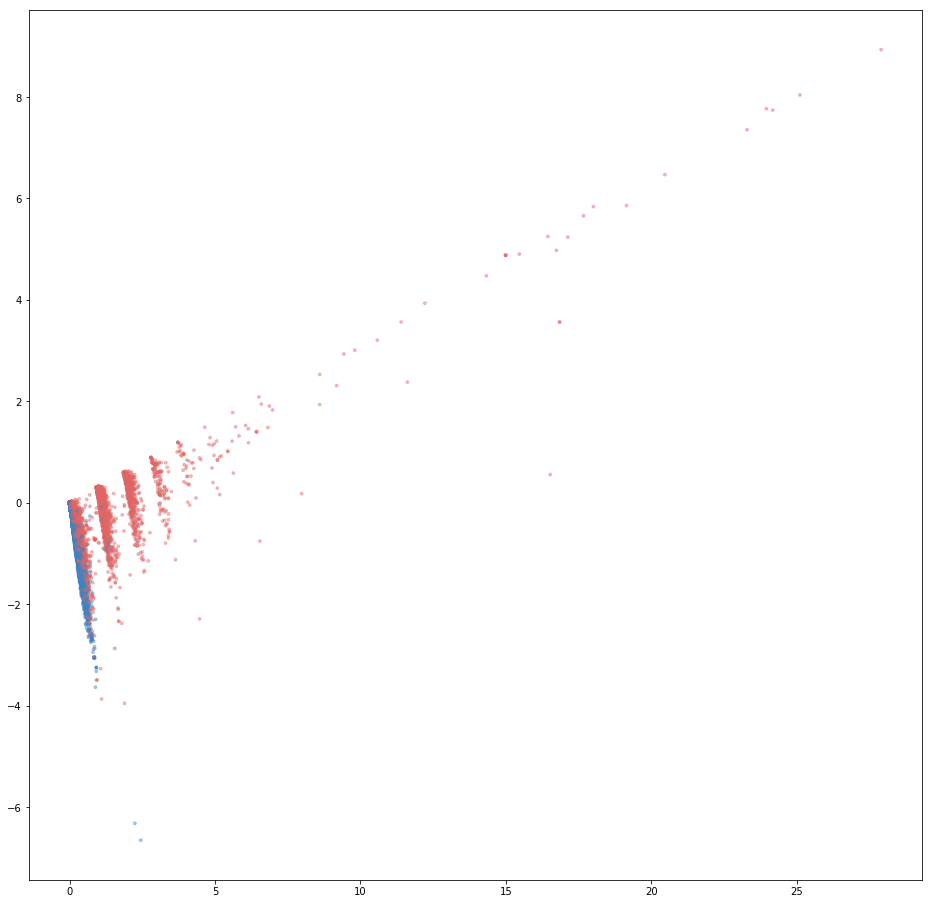

In [260]:
# visualize embeddings
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['#3d85c6','#e06666']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.4, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='#3d85c6', label='Not Abusive')
            green_patch = mpatches.Patch(color='#e06666', label='Abusive')
            #plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [191]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [192]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.850, precision = 0.850, recall = 0.850, f1 = 0.850


In [210]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="black" if cm[i, j] < thresh else "white", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

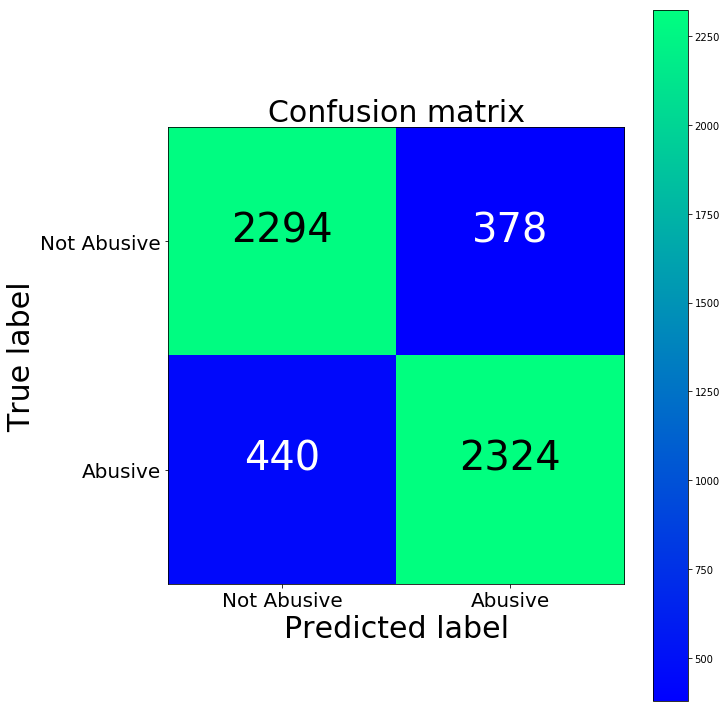

[[2294  378]
 [ 440 2324]]


In [194]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Abusive','Abusive'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [195]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)
print(importance[0])

{'tops': [(4.241356337857435, 'moron'), (4.4017273722548715, 'federalist'), (4.403753309282546, 'flamboyantli'), (4.412027718660226, 'cunt'), (4.413176996618754, 'fuck'), (4.523064594899984, 'fucker'), (4.56044367682667, 'asshol'), (4.653402901642557, 'ergo'), (4.9687542000582665, 'bitch'), (5.327503490502627, 'rapist')], 'bottom': [(-4.30624565336242, 'invol'), (-4.33701296445427, 'amazestar'), (-4.4466704217715805, 'lea'), (-4.576327393165323, 'overact'), (-4.599501697794031, 'chuch'), (-4.743082518412887, 'generali'), (-4.944651991587398, 'drown'), (-5.156879710985093, 'connot'), (-5.465628232068156, 'inexc'), (-5.952633466669084, 'supertal')]}


In [196]:
clf.coef_.shape

(1, 27904)

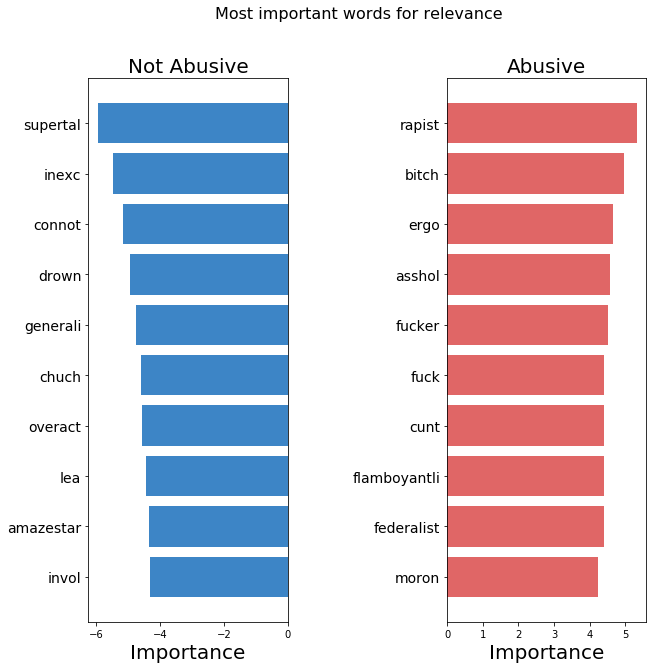

In [273]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=1, color = '#3d85c6')
    plt.title('Not Abusive', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=1, color = '#e06666')
    plt.title('Abusive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [198]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

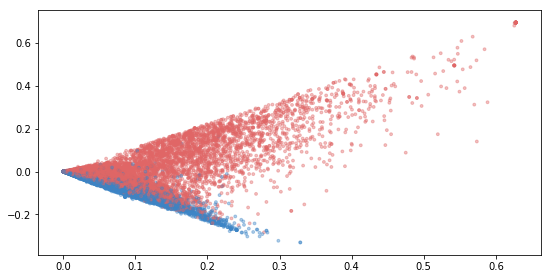

In [261]:
fig = plt.figure(figsize=(9, 4.5))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [245]:
clf_tfidf = LogisticRegression(C=3, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [246]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.875, precision = 0.877, recall = 0.875, f1 = 0.875


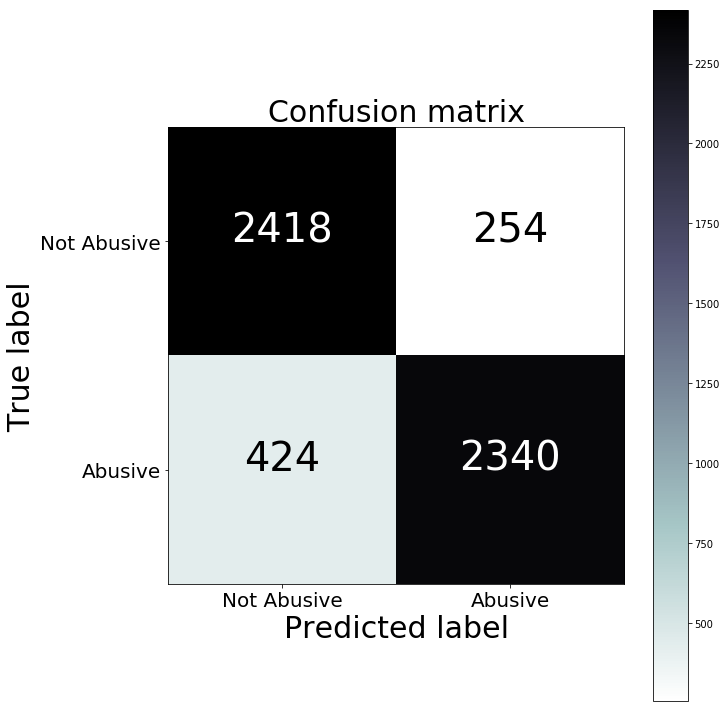

TFIDF confusion matrix
[[2418  254]
 [ 424 2340]]
BoW confusion matrix
[[2294  378]
 [ 440 2324]]


In [247]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not Abusive','Abusive'], normalize=False, title='Confusion matrix', cmap = plt.cm.bone_r)
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [265]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 5)

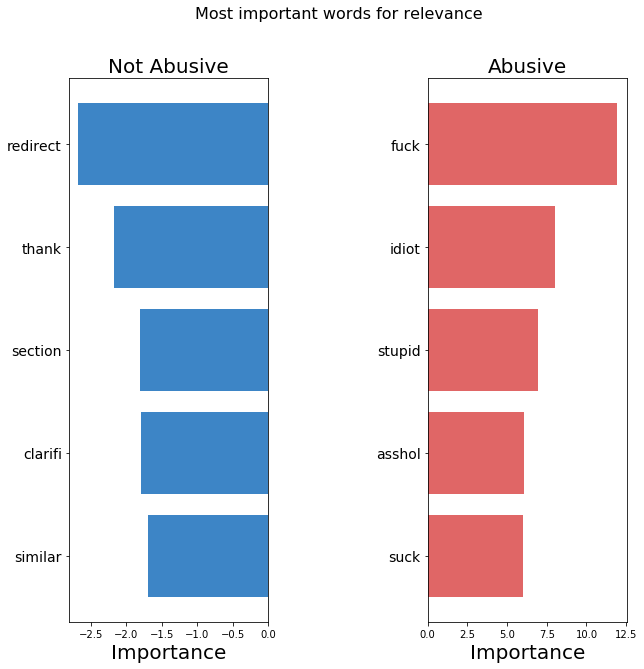

In [274]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [250]:
#import gensim

#word2vec_path = "../../../GoogleNews-vectors-negative300.bin.gz"
#word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [251]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [252]:
embeddings = get_word2vec_embeddings(word2vec, wi_balanced)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

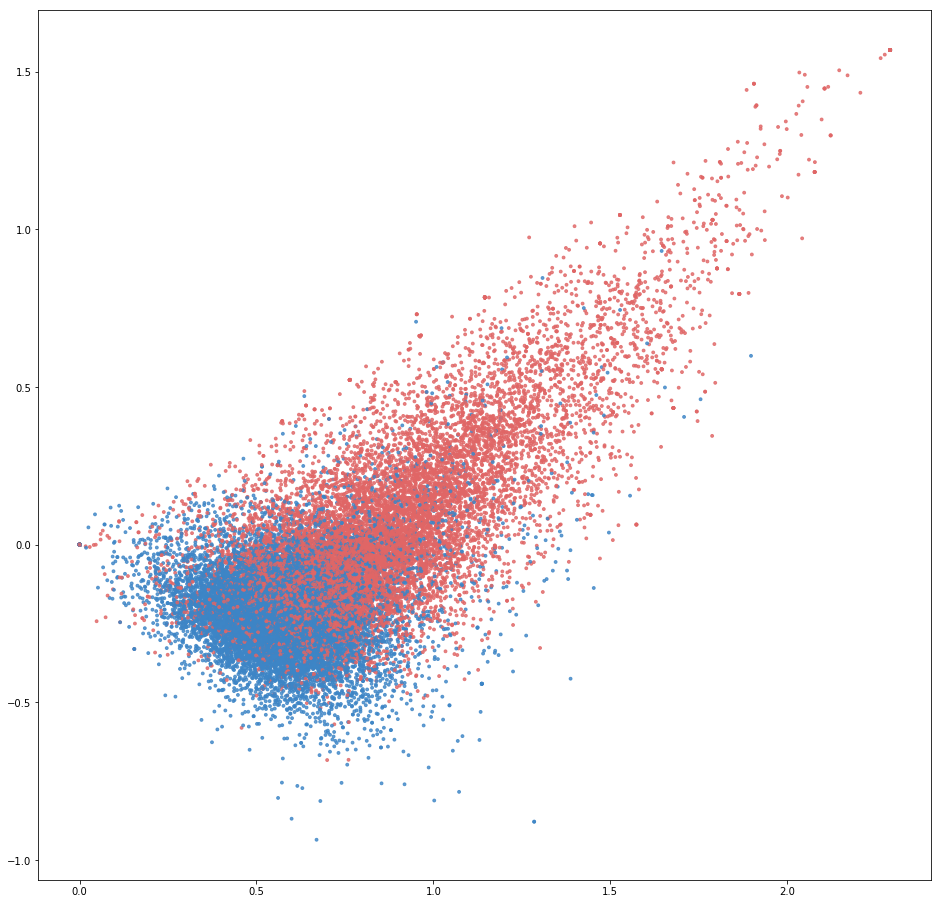

In [253]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [258]:
clf_w2v = LogisticRegression(C=100, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [259]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.837, precision = 0.841, recall = 0.837, f1 = 0.837


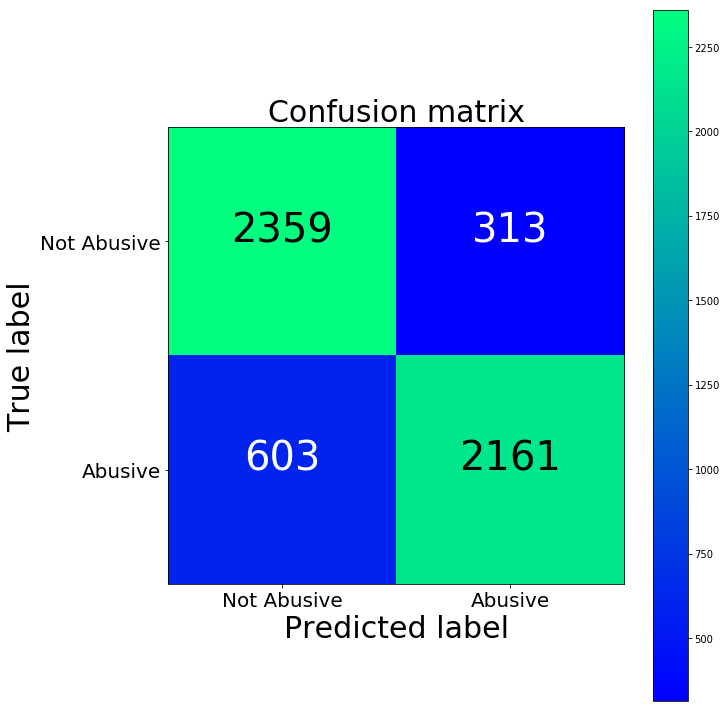

Word2Vec confusion matrix
[[2359  313]
 [ 603 2161]]
TFIDF confusion matrix
[[2317  355]
 [ 433 2331]]
BoW confusion matrix
[[2237  435]
 [ 454 2310]]


In [181]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['Not Abusive','Abusive'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [ ]:
# lemmatized:
Word2Vec confusion matrix
[[2348  324]
 [ 500 2264]]
TFIDF confusion matrix
[[2352  320]
 [ 435 2329]]
BoW confusion matrix
[[2293  379]
 [ 446 2318]]

# porter
Word2Vec confusion matrix
[[2374  298]
 [ 585 2179]]
TFIDF confusion matrix
[[2355  317]
 [ 426 2338]]
BoW confusion matrix
[[2294  378]
 [ 440 2324]]

# snowball
Word2Vec confusion matrix
[[2367  305]
 [ 570 2194]]
TFIDF confusion matrix
[[2350  322]
 [ 430 2334]]
BoW confusion matrix
[[2287  385]
 [ 442 2322]]

# lancaster
Word2Vec confusion matrix
[[2359  313]
 [ 603 2161]]
TFIDF confusion matrix
[[2317  355]
 [ 433 2331]]
BoW confusion matrix
[[2237  435]
 [ 454 2310]]

In [277]:
all_words = [word for tokens in wi_balanced["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in wi_balanced["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

418117 words total, with a vocabulary size of 31760
Max sentence length is 70


In [280]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(wi_balanced["p_comment"].tolist())
sequences = tokenizer.texts_to_sequences(wi_balanced["p_comment"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(wi_balanced["troll"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 31704 unique tokens.
(31705, 300)


In [281]:
from keras.layers import Dense, Input, Flatten, Dropout, Merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [283]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(wi_balanced["troll"].unique())), False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [284]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Train on 21744 samples, validate on 5436 samples
Epoch 1/3
21744/21744 [==============================] - 17s 765us/step - loss: 0.4964 - acc: 0.7494 - val_loss: 0.3891 - val_acc: 0.8341
Epoch 2/3
21744/21744 [==============================] - 16s 717us/step - loss: 0.3492 - acc: 0.8519 - val_loss: 0.4123 - val_acc: 0.8140
Epoch 3/3
21744/21744 [==============================] - 16s 735us/step - loss: 0.3051 - acc: 0.8702 - val_loss: 0.3349 - val_acc: 0.8547


In [287]:
y_keras = model.predict((x_val))

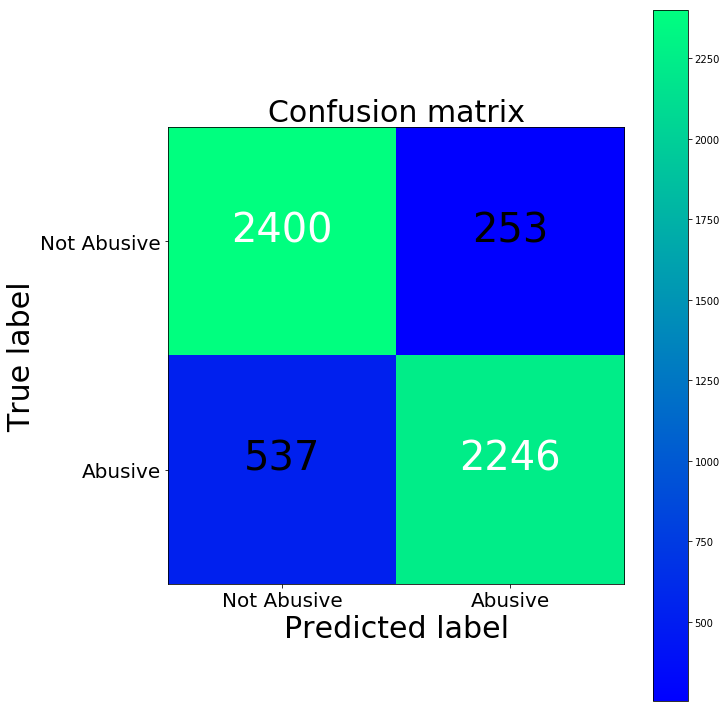

Word2Vec confusion matrix
[[2359  313]
 [ 603 2161]]
TFIDF confusion matrix
[[2418  254]
 [ 424 2340]]
BoW confusion matrix
[[2294  378]
 [ 440 2324]]


In [288]:
k_w2v = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_keras, axis=1))
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(k_w2v, classes=['Not Abusive','Abusive'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)